# Exoplanet Hunting

This is the first part of a two-part workshop focused on classifying exoplanet candidates observed by the Kepler space telescope. This data set is not easy to work with, and the focus of this first workshop is to study and clean the data.


<p float="left">
  <img src="https://upload.wikimedia.org/wikipedia/commons/4/45/Kepler_Space_Telescope_spacecraft_model_2.png" width="200" />
  <img src="https://exoplanets.nasa.gov/system/resources/detail_files/280_656348main_ToV_transit_diag.jpg" width="500" /> 
</p>

Data described and avaliable at https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data/

The following two links describes how Kepler observes exoplanets: [video1](https://www.youtube.com/watch?v=RrusIZaWDW8) and [video2](https://www.youtube.com/watch?v=ku7YjMol1k4). For extra credit here is a video proving that Kepler observed an [alien superstructure!](https://www.youtube.com/watch?v=nlDv7FspChA)

Before we begin, download and unzip the training and test data sets into the `./data/` folder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(f'Pandas version {pd.__version__}')

Pandas version 0.25.1


In [4]:
def load_data(path):
    train_data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(train_data.columns):
        if 'FLUX' in column:
            train_data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    train_data.LABEL -= 1
    return train_data

train_data = load_data('./exoTrain.csv')

LABEL -> 1 is an exoplanet star and 0 is a non-exoplanet-star.

Columns 1-3197 -> the light intensity recorded for each star, at a different point in time during the 80 day campaign

In [5]:
train_data.head()

,LABEL,1,2,3,4,5,6,7,8,9,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Data set ballance
How many exoplanet and non-exoplanet labels are there?

In [6]:
print(f'Number of exoplanet labels {sum(train_data.LABEL == 1)}')
print(f'Number of non-exoplanet labels {sum(train_data.LABEL == 0)}')

Number of exoplanet labels 37
Number of non-exoplanet labels 5050


This is a very unballanced data set. Maybe the 37 exoplanets are very large (similar size to Jupiter and relatively easy to detect), but those planets are less common as smaller planets?

## Visualize exoplanet and non-exoplanet light curves.

First lets pick n_plots number of random exoplanet and non-exoplanet examples and save to new DataFrames. For each example we will also calculate a n_smooth running average. The running average calculation is nearly identical to a convolution and is the central concept in a Convolutional Naural Network that we will use to classify Kepler light curves as exoplanet or non-exoplanet.

In [14]:
n_plots = 5
n_smooth = 100 # Number of data points to smooth (boxcar average) over

exo_df = train_data[train_data.LABEL == 1].sample(n=n_plots, random_state=123)
nonexo_df = train_data[train_data.LABEL == 0].sample(n=n_plots, random_state=123)

exo_df_rolling = exo_df.rolling(n_smooth, axis=1, center=True).mean()
nonexo_df_rolling = nonexo_df.rolling(n_smooth, axis=1, center=True).mean()

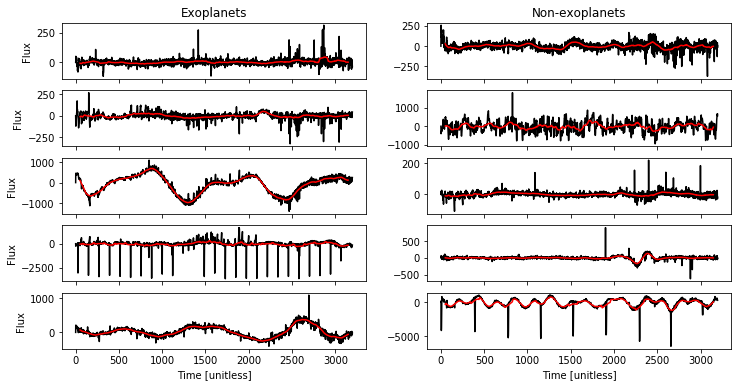

In [15]:
_, ax = plt.subplots(n_plots, 2, figsize=(12, 6), sharex=True)

for i, a in enumerate(ax[:, 0]): 
    a.plot(exo_df.iloc[i, :].values, 'k')
    a.plot(exo_df_rolling.values[i, :], 'r')
    a.set_ylabel('Flux')
for i, a in enumerate(ax[:, 1]): 
    a.plot(nonexo_df.iloc[i, :].values, 'k')
    a.plot(nonexo_df_rolling.values[i, :], 'r')
ax[0,0].set(title='Exoplanets')
ax[0,1].set(title='Non-exoplanets')
ax[-1,0].set_xlabel('Time [unitless]')
ax[-1,1].set_xlabel('Time [unitless]');

## Power spectrum
By visual inspection it is hard to tell the difference. What about the Fourier power spectrum?

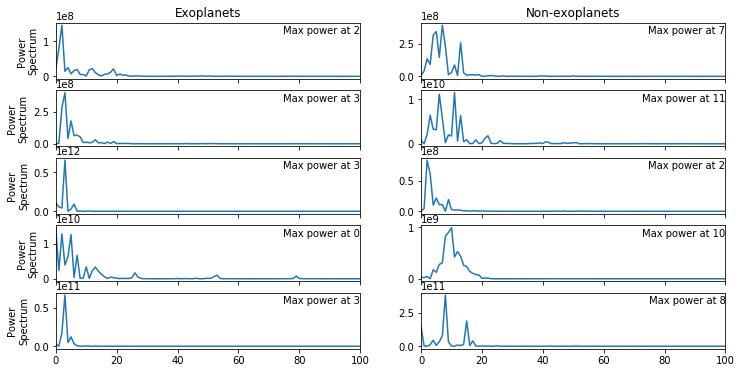

In [9]:
# Fill NaNs with 0s so numpy fft can handle the data correctly.
exo_df_rolling = exo_df_rolling.fillna(value=0)
nonexo_df_rolling = nonexo_df_rolling.fillna(value=0)

def calc_fourier_power(df):
    """
    Calculates the Fourier power spectrum and returns
    the frequency with the highest power.
    """
    ps = np.abs(np.fft.fft(df.values))**2
    max_power_f = np.argmax(ps[:len(ps)//2])
    return ps, max_power_f

### Plot the power spectra ###
_, ax = plt.subplots(n_plots, 2, figsize=(12, 6), sharex=True)

for i, a in enumerate(ax[:, 0]): 
    ps, max_power_f = calc_fourier_power(exo_df_rolling.iloc[i, :])
    a.plot(ps)
    a.text(1, 0.8, f'Max power at {max_power_f}', 
            ha='right', transform=a.transAxes)
    a.set_ylabel('Power\nSpectrum')

for i, a in enumerate(ax[:, 1]): 
    ps, max_power_f = calc_fourier_power(nonexo_df_rolling.iloc[i, :])
    a.text(1, 0.8, f'Max power at {max_power_f}', 
            ha='right', transform=a.transAxes)
    a.plot(ps)

ax[0,0].set(title='Exoplanets', xlim=(0, 100))
ax[0,1].set(title='Non-exoplanets');

There does not seem to be a pattern in this data so lets throw the biggest hammer I can think of---a [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network)! Next workshop we will develop a CNN to classify this data set. Since this data set is far from ideal, we have three tasks:

1. write a function to normalize each light curve by
    * subtracticting the mean and 
    * dividing by the standard deviation 
    
2. write a batch [generator](https://realpython.com/introduction-to-python-generators/) (a lazy function) that outputs a batch_size number of random light curves with HALF exoplanets and HALF non-exoplanets given: the training set, training labels, and a batch_size arguments.
    * the batch generator needs to include a preprocessing step: [Augmentation](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/). While the tutorial link deals with image augmentation, think of ways to augment time series data.
    * half exoplanet/half nonexoplanet batch generator requirement is our attempt to ballance the data set.
    
4. install tensorflow. I am using tensorflow version 2.0.0-beta1

In [43]:
exo_mean = np.mean(exo_df.values[:,1:], axis=1)
exo_std = np.std(exo_df.values[:,1:], axis=1)
exo_mean, exo_std

(array([ 1.26778855e+00,  5.91179231e-02, -9.62563779e+01, -4.17263153e+01,
         1.80155802e+01]),
 array([ 28.39137276,  37.11112833, 440.46428442, 473.05013516,
        155.65995673]))

In [77]:
train_mean = np.reshape(train_data.values[:,1:].mean(axis=1), (1,5087))
train_std = np.reshape(train_data.values[:,1:].std(axis=1), (1,5087))
train_mean, train_std, train_mean.shape, train_std.shape

(array([[ 9.95385674, -7.42793244,  8.18908664, ...,  2.93976228,
          0.80310916,  5.19516734]]),
 array([[160.70334797,  60.0016378 , 281.8323965 , ...,  61.36366455,
          10.97093267,  61.61472301]]),
 (1, 5087),
 (1, 5087))

In [88]:
train_norm = (train_data.values[:,1:] - train_mean.T)/train_std.T
train_norm

array([[ 0.52205598,  0.45958061,  0.06313585, ...,  0.32025558,
        -0.03032828, -0.30798274],
       [-0.52418682, -0.44002245, -0.85184454, ...,  0.23145922,
         0.39045488,  0.45595309],
       [ 1.86086099,  1.87249912,  1.79376438, ..., -0.13163528,
        -0.27750212, -0.37206186],
       ...,
       [ 4.40733518,  4.48246107,  4.21732046, ...,  1.39301064,
         1.24064034,  1.24650701],
       [ 0.27498946,  0.11730004, -0.37308671, ..., -1.39943518,
        -0.65747456, -0.30563574],
       [ 5.16248093,  4.88787124,  4.67363673, ..., -0.35568069,
        -0.31299609,  0.36719848]])

In [87]:
train_data.values[:,1:]

array([[ 93.85,  83.81,  20.1 , ...,  61.42,   5.08, -39.54],
       [-38.88, -33.83, -58.54, ...,   6.46,  16.  ,  19.93],
       [532.64, 535.92, 513.73, ..., -28.91, -70.02, -96.67],
       ...,
       [273.39, 278.  , 261.73, ...,  88.42,  79.07,  79.43],
       [  3.82,   2.09,  -3.29, ..., -14.55,  -6.41,  -2.55],
       [323.28, 306.36, 293.16, ..., -16.72, -14.09,  27.82]])

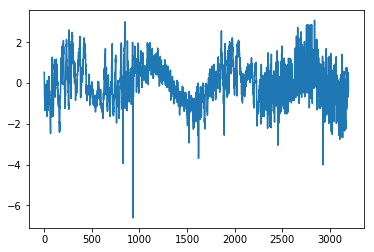

In [93]:
plt.plot(train_norm[0])